In [2]:
# dataset param
DATA_PATH = "C:/Users/liuyi/segment/ubdd/xbd/output_mask2/"
IMG_SIZE = (224, 224)
NCLASS = 4
BATCH_SIZE = 32
VAL_SPLIT = 0.15
import os
NUMWORKERS = os.cpu_count()
# DATA_PATH = "../output_mask2/"
# IMG_SIZE = (224, 224)
# NCLASS = 4
# BATCH_SIZE = 32
# VAL_SPLIT = 0.15
# NUMWORKERS = 4

# model training hparam
EPOCH = 10
SAVE_INTERVAL = EPOCH // 10
 # 用于自己debug
TEST_EPOCH = 2
TEST_SAVE_INTERVAL = 1

LR = 1e-3
FOCAL_GAMMA = 1
FOCAL_ALPHA = None


# eval param
PLOT_PATH = "plots_classification/"
MODEL_PATH = "model_classification/"

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
import json
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# augmentations                         
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# creating dataset and loader using image folder
full_dataset = ImageFolder(DATA_PATH, transform=train_transform)
full_dataset_test = ImageFolder(DATA_PATH, transform=test_transform)

data_idx = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(data_idx, test_size=VAL_SPLIT, random_state=100)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset_test, val_idx)
print(f"total:{len(full_dataset)}\ntraining:{len(train_dataset)} validation:{len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUMWORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, num_workers=NUMWORKERS, pin_memory=True)

total:107004
training:90953 validation:16051


In [3]:
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import torchmetrics.functional as MF
import matplotlib.pyplot as plt
import os

def model_train(dataloader, model, loss_func, optimizer, current_epoch):
    avg_loss = 0
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    cur_len = 1
    
    model.train()
    prog_bar = tqdm(dataloader, desc=f'Epoch: {current_epoch}', unit='batch')
    for x,y in prog_bar:
        pred = model(x.to(DEVICE))
        target = y.to(DEVICE)
        #pred = F.softmax(pred, dim=1)
        #print(pred.size())
        loss = loss_func(pred, target)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # eval
        acc = MF.accuracy(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)
        prec = MF.precision(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)
        rec = MF.recall(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)

        avg_loss += loss.item()
        avg_acc += acc
        avg_prec += prec
        avg_rec += rec

        prog_bar.set_postfix_str(f'train accuracy:{avg_acc/cur_len:.3f}, loss:{avg_loss/cur_len:.3f}, prec:{avg_prec/cur_len:.3f}, rec:{avg_rec/cur_len:.3f}')
        cur_len += 1
    
    # count avg
    data_len = len(dataloader)
    avg_loss /= data_len
    avg_acc /= data_len
    avg_prec /= data_len
    avg_rec /= data_len

    f1 = (2 * avg_prec * avg_rec) / (avg_prec + avg_rec)

    history = {
        'loss': avg_loss,
        'accuracy' : avg_acc,
        'precision' : avg_prec,
        'recall' : avg_rec,
        'f1_score' : f1
    }

    return history

def model_predict(dataloader, model, loss_func, silent=True, save_prediction=False):
    avg_loss = 0
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    
    predictions = torch.tensor([]).to(DEVICE)
    targets = torch.tensor([], dtype=torch.int64).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, desc='Predicting', unit='batch', disable=silent):
            pred = model(x.to(DEVICE))
            target = y.to(DEVICE)
            #pred = F.softmax(pred, dim=1)
            loss = loss_func(pred, target)

            acc = MF.accuracy(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)
            prec = MF.precision(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)
            rec = MF.recall(pred, target, task='multiclass', average='macro', num_classes=NCLASS, top_k=1, validate_args=False)
            
            avg_loss += loss.item()
            avg_acc += acc
            avg_prec += prec
            avg_rec += rec
            
            predictions = torch.cat((predictions, pred), dim=0)
            targets = torch.cat((targets, target), dim=0)
        
    data_len = len(dataloader)
    avg_loss /= data_len
    avg_acc /= data_len
    avg_prec /= data_len
    avg_rec /= data_len

    f1 = (2 * avg_prec * avg_rec) / (avg_prec + avg_rec)
    
    rocauc = MF.auroc(predictions, targets, task='multiclass', num_classes=NCLASS, average='macro')
    if not silent:
        print(f"roc-auc:{rocauc.item()}")

    result = {
        'predictions' : predictions if save_prediction else None,
        'targets' : targets if save_prediction else None,
        'rocauc' : rocauc,
        'loss': avg_loss,
        'accuracy' : avg_acc,
        'precision' : avg_prec,
        'recall' : avg_rec,
        'f1_score' : f1
    }

    return result

def add_history(history_list, train_history, val_result):
    history_list['loss'].append(train_history['loss'])
    history_list['acc'].append(train_history['accuracy'].item())
    history_list['prec'].append(train_history['precision'].item())
    history_list['rec'].append(train_history['recall'].item())
    history_list['f1'].append(train_history['f1_score'].item())

    history_list['val_loss'].append(val_result['loss'])
    history_list['val_acc'].append(val_result['accuracy'].item())
    history_list['val_prec'].append(val_result['precision'].item())
    history_list['val_rec'].append(val_result['recall'].item())
    history_list['val_f1'].append(val_result['f1_score'].item())
    history_list['rocauc'].append(val_result['rocauc'].item())

    return history_list

def print_history(history:dict):
    print(f"training accuracy:{history['acc'][-1]:.3f}, precision:{history['prec'][-1]:.3f}, recall:{history['rec'][-1]:.3f}, f1:{history['f1'][-1]:.3f}")
    print(f"validation accuracy:{history['val_acc'][-1]:.3f}, precision:{history['val_prec'][-1]:.3f}, recall:{history['val_rec'][-1]:.3f}, f1:{history['val_f1'][-1]:.3f}")

def plot_history(history:dict):
    if not os.path.isdir(PLOT_PATH):
        os.mkdir(PLOT_PATH)

    label = {
        'loss' : 'loss',
        'acc' : 'accuracy',
        'prec' : 'precision',
        'rec' : 'recall',
        'f1' : 'f1 score',
    }
    
    keys = ['loss', 'acc', 'prec', 'rec', 'f1']
    
    for k in keys:
        plt.figure(figsize=(8, 8))
        plt.plot(history[k])
        plt.plot(history['val_'+k])
        plt.xlabel('epoch')
        plt.ylabel(label[k])
        plt.legend(['training', 'validation'], loc='right')

        save_path = os.path.join(PLOT_PATH, f"{label[k]}.png")
        plt.savefig(save_path, bbox_inches='tight')


In [4]:
# focal loss
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

def freeze_layer(model, freeze_pct):
    # if freeze_layer <= 0:
    if freeze_pct <= 0:
        return
    
    length = 0
    names_list = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            length += 1
        names_list.append(name)
    names_list.append('end')

    cur = 0
    delay = False
    a = [] #
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            idx = names_list.index(name)
            if 'bias' in names_list[idx+1]:
                delay = True
            cur += 1
            param.requires_grad = False
            a.append(name) #
        elif param.requires_grad and 'bias' in name:
            param.requires_grad = False
            a.append(name) #
            delay = False
        
        if (cur/length) >= freeze_pct and not delay:
            break
    
    return model

### ResNet

Predicting: 100%|██████████| 502/502 [01:59<00:00,  4.19batch/s]


roc-auc:0.8502748012542725


Predicting: 100%|██████████| 502/502 [01:57<00:00,  4.26batch/s]


roc-auc:0.8635395765304565
training accuracy:0.504, precision:0.584, recall:0.504, f1:0.541
validation accuracy:0.540, precision:0.599, recall:0.540, f1:0.568


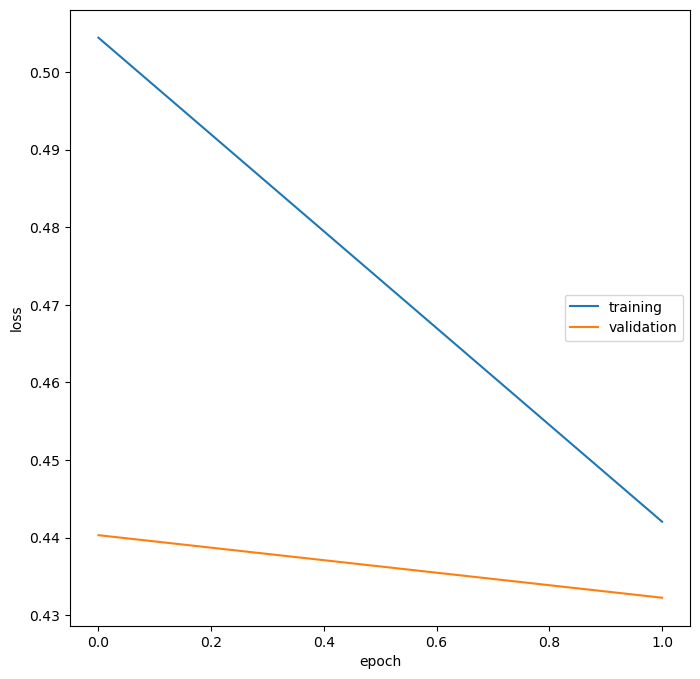

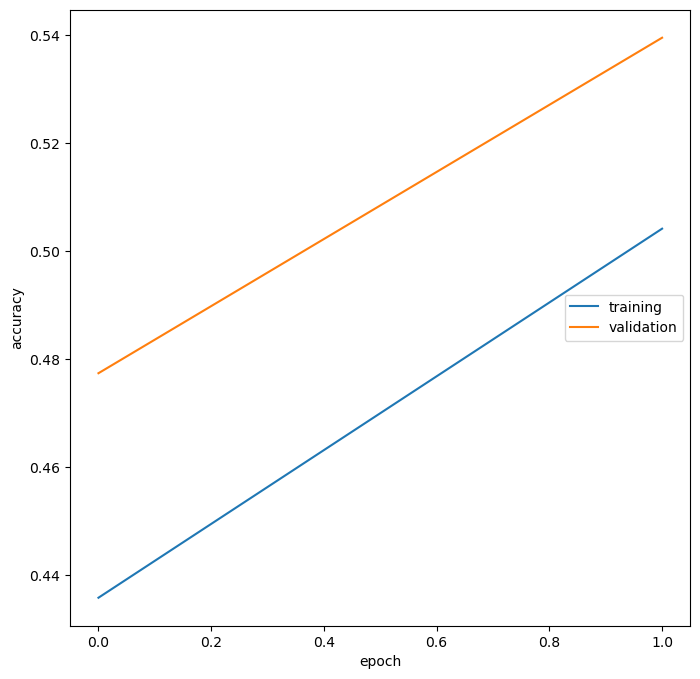

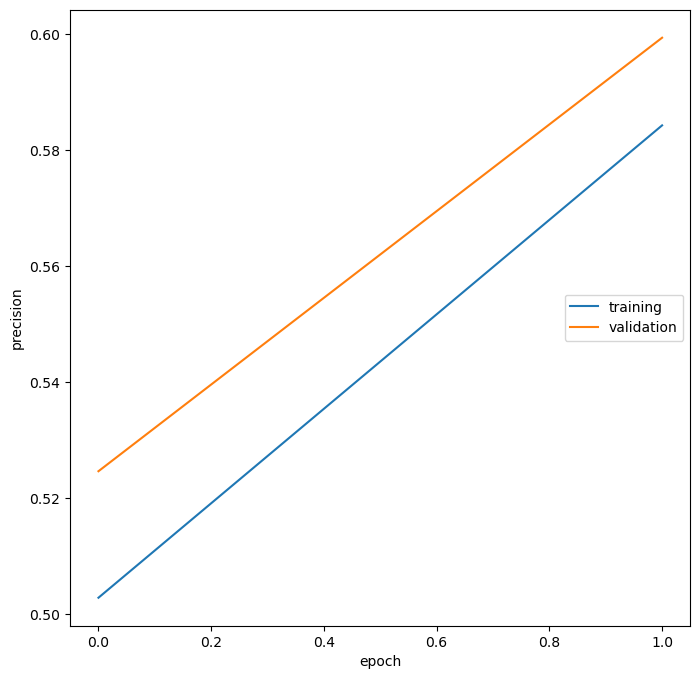

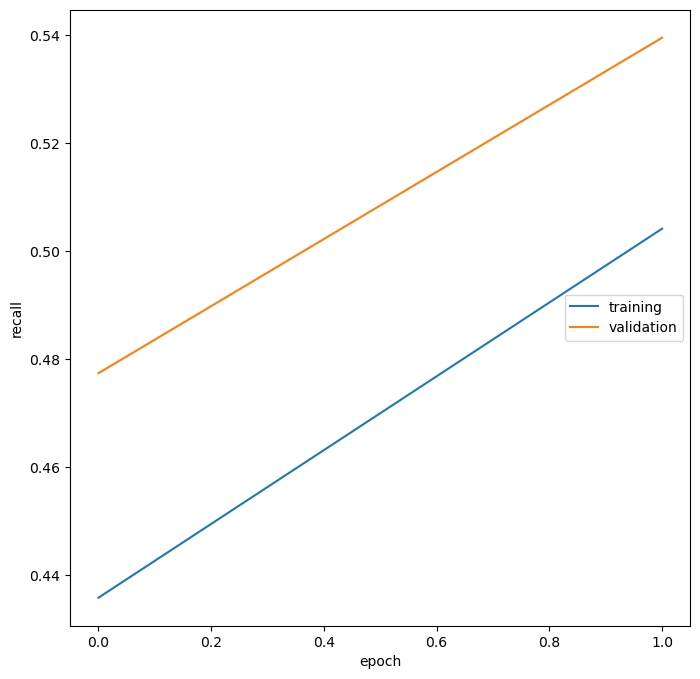

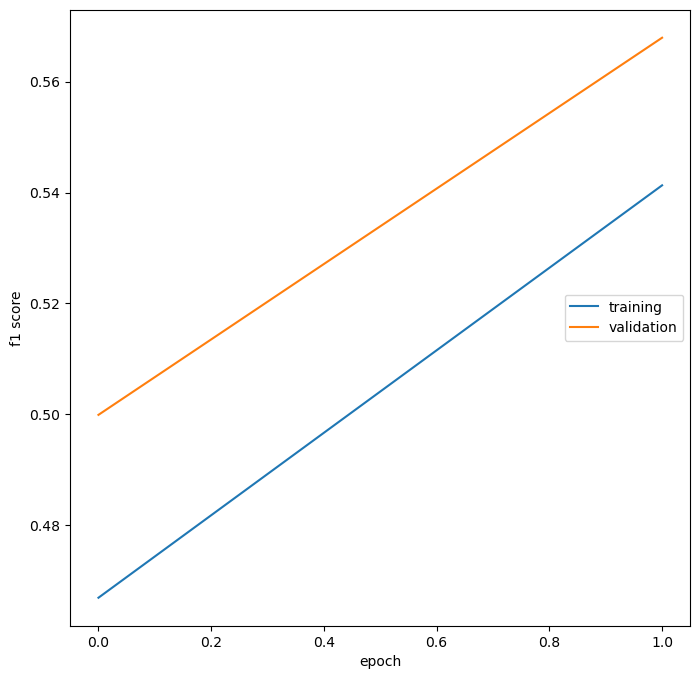

In [5]:
from torchvision.models import resnet50
from datetime import datetime

model = resnet50(weights='DEFAULT')
model_name = 'resnet50'
model.fc = nn.Linear(2048, NCLASS)
freeze_layer(model, freeze_pct=0) # freeze layer
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

# make directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"{model_name}_{timestamp}"

os.makedirs(folder_name, exist_ok=True)

# training loop
for i in range(TEST_EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)
    
    # save history and model
    with open(f'training_history_epoch_{i+1}.json', 'w') as f:
        json.dump(history, f)
    if (i + 1) % TEST_SAVE_INTERVAL == 0:
        state = {
            'model_name': model_name,
            'epoch': i + 1,
            'state_dict': model.state_dict(),
            'optimizer': adam.state_dict(),
        }
        torch.save(state, os.path.join(folder_name,
                                       f"{model_name}_classification_epoch_{i+1}.pth"))
        
# save final history
with open('training_history_final.json', 'w') as f:
    json.dump(history, f)
    
    
    #print(f"validation accuracy:{val_result['accuracy']}, precision:{val_result['precision']}, recall:{val_result['recall']}, f1 score:{val_result['f1_score']}")

print_history(history)
# 绘制训练曲线
plot_history(history)

In [1]:
# 从 JSON 文件中加载历史数据 不用可以注释掉
with open('training_history_final.json', 'r') as f:
    history = json.load(f)
plot_history(history)

NameError: name 'plot_history' is not defined

In [7]:
from torchvision.models import resnet152

model = resnet152(weights='DEFAULT')
model.fc = nn.Linear(2048, NCLASS)
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

# training loop
for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\liuyi/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:08<00:00, 27.8MB/s] 
Epoch: 1:   1%|▏         | 40/2843 [07:31<8:47:15, 11.29s/batch, train accuracy:0.300, loss:0.680, prec:0.274, rec:0.300]


KeyboardInterrupt: 

***

### EfficientNet

In [17]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights='DEFAULT')
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(1280, NCLASS)
)
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:46<00:00, 10.77batch/s]


roc-auc:0.8832800984382629


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:20<00:00, 24.47batch/s]


roc-auc:0.8950924873352051


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.59batch/s]


roc-auc:0.9127956032752991


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.41batch/s]


roc-auc:0.9079384803771973


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.53batch/s]


roc-auc:0.9099280834197998


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.54batch/s]


roc-auc:0.9195245504379272


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.46batch/s]


roc-auc:0.9285060167312622


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.31batch/s]


roc-auc:0.9266307353973389


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:19<00:00, 25.36batch/s]


roc-auc:0.9149775505065918


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:54<00:00,  9.13batch/s]

roc-auc:0.9302471876144409
training accuracy:0.655, precision:0.700, recall:0.655, f1:0.677
validation accuracy:0.683, precision:0.696, recall:0.683, f1:0.689


In [9]:
from torchvision.models import efficientnet_b4

model = efficientnet_b4(weights='DEFAULT')
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(1792, NCLASS)
)
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.25batch/s]


roc-auc:0.8944668769836426


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [01:48<00:00,  4.63batch/s]


roc-auc:0.9049273133277893


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.19batch/s]


roc-auc:0.915663480758667


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.22batch/s]


roc-auc:0.9185037016868591


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.22batch/s]


roc-auc:0.9235542416572571


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [02:24<00:00,  3.48batch/s]


roc-auc:0.9271314740180969


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.16batch/s]


roc-auc:0.929146945476532


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.21batch/s]


roc-auc:0.9277873039245605


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:44<00:00, 11.25batch/s]


roc-auc:0.931045413017273


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [01:54<00:00,  4.39batch/s]

roc-auc:0.9302316904067993
training accuracy:0.686, precision:0.719, recall:0.686, f1:0.702
validation accuracy:0.670, precision:0.708, recall:0.670, f1:0.688


***

### ShuffleNet

In [16]:
from torchvision.models import shufflenet_v2_x1_0

model = shufflenet_v2_x1_0(weights='DEFAULT')
model.fc = nn.Linear(1024, NCLASS)
#freeze_layer(model, freeze_pct=0.2)
model = model.to(DEVICE)

#loss_weight = torch.cuda.FloatTensor([0.15, 1.0, 1.0, 1.0])
#ce = nn.CrossEntropyLoss(weight=loss_weight)
focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)
#adam = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:11<00:00, 41.84batch/s]


roc-auc:0.8823245763778687


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.73batch/s]


roc-auc:0.8975889086723328


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.37batch/s]


roc-auc:0.9067186713218689


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.55batch/s]


roc-auc:0.9094777703285217


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.22batch/s]


roc-auc:0.914448618888855


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.92batch/s]


roc-auc:0.9164899587631226


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.70batch/s]


roc-auc:0.9173678755760193


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.50batch/s]


roc-auc:0.9191175699234009


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 38.87batch/s]


roc-auc:0.9241763353347778


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.81batch/s]

roc-auc:0.9187948703765869
training accuracy:0.636, precision:0.691, recall:0.636, f1:0.662
validation accuracy:0.661, precision:0.685, recall:0.661, f1:0.673


In [4]:
from torchvision.models import shufflenet_v2_x0_5

model = shufflenet_v2_x0_5(weights='DEFAULT')
model.fc = nn.Linear(1024, NCLASS)
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to C:\Users\Edy Irwansyah/.cache\torch\hub\checkpoints\shufflenetv2_x0.5-f707e7126e.pth
100%|█████████████████████████████████████████████████████████████████████████████| 5.28M/5.28M [00:01<00:00, 3.04MB/s]
Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [04:10<00:00,  2.00batch/s]


roc-auc:0.8706121444702148


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:13<00:00, 38.61batch/s]


roc-auc:0.8807520866394043


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.30batch/s]


roc-auc:0.8929417133331299


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.22batch/s]


roc-auc:0.8946371078491211


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.51batch/s]


roc-auc:0.9015276432037354


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 41.02batch/s]


roc-auc:0.9053434133529663


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 39.98batch/s]


roc-auc:0.9074108004570007


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.94batch/s]


roc-auc:0.9090672731399536


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.17batch/s]


roc-auc:0.9105983972549438


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:12<00:00, 40.52batch/s]

roc-auc:0.9150599241256714
training accuracy:0.624, precision:0.686, recall:0.624, f1:0.653
validation accuracy:0.633, precision:0.674, recall:0.633, f1:0.653


In [6]:
from torchvision.models import shufflenet_v2_x2_0

model = shufflenet_v2_x2_0(weights='DEFAULT')
model.fc = nn.Linear(2048, NCLASS)
model = model.to(DEVICE)

focal = FocalLoss(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
adam = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    'loss' : [],
    'acc' : [],
    'prec' : [],
    'rec' : [],
    'f1' : [],
    'val_loss' : [],
    'val_acc' : [],
    'val_prec' : [],
    'val_rec' : [],
    'val_f1' : [],
    'rocauc' : []
}

for i in range(EPOCH):
    train_history = model_train(train_dataloader, model, focal, adam, i+1)
    val_result = model_predict(val_dataloader, model, focal, silent=False)

    history = add_history(history, train_history, val_result)

print_history(history)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to C:\Users\Edy Irwansyah/.cache\torch\hub\checkpoints\shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████████████████████████████████████████████████████████████████████████| 28.4M/28.4M [00:40<00:00, 734kB/s]
Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:29<00:00, 17.23batch/s]


roc-auc:0.8615797758102417


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.17batch/s]


roc-auc:0.8887726068496704


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.67batch/s]


roc-auc:0.9012756943702698


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.54batch/s]


roc-auc:0.8989168405532837


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.44batch/s]


roc-auc:0.9073429107666016


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.75batch/s]


roc-auc:0.9167101383209229


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.41batch/s]


roc-auc:0.9168139696121216


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.80batch/s]


roc-auc:0.9177054166793823


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.34batch/s]


roc-auc:0.9217766523361206


Predicting: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:16<00:00, 30.56batch/s]

roc-auc:0.9191476106643677
training accuracy:0.640, precision:0.696, recall:0.640, f1:0.667
validation accuracy:0.640, precision:0.689, recall:0.640, f1:0.664


***